In [112]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Problem description
You are a gamer in a FIFA competition. The competition is a fantasy-based league, where you bid for a squad of 22 players. Every player is available for the auction until they’ve been sold. In other words, once a player is selected in/sold to a team, they can’t be bought by another team. Given there’s a salary cap to be decided closer to the auction, how would you prepare and prioritise in selecting the 22 players in your squad?

In [113]:
fifadata = pd.read_csv('data/data.csv')

In [114]:
# Pre-process to Convert Currency
def currency_to_float(cval, currency = '€'):
    """
    Converts currency values into float data types
    Arguments:
        cval: a currency encoded string value e.g. '60K' or '118.5M'
        currency: the currency to convert from defaults to '€'
    Returns:
        float value representation of the data
    Example:
        currency_to_float('20.5M')
    """
    # replaces the euro symbol
    cval = cval.replace(currency,'')
    if 'M' in cval:
        cval = cval.replace('M','')
        cval = float(cval) * (10**6)
    elif 'K' in cval:
        cval = cval.replace('K','')
        cval = float(cval) * (10**3)
    else:
        cval = float(cval)
    return(cval)

fifadata['Value_converted'] = fifadata.Value.apply(currency_to_float)

In [115]:
# Deprecated diagnostic plots
# sns.distplot(fifadata.Overall)
# sns.distplot(fifadata.Value_converted)
#sns.distplot(fifadata.Value_converted[fifadata.Value_converted > 0] )

## Exploring Data

Focusing on the relationship between overall rating & player cost indicates that well ranked players are paid the most however the relationship is not linear


C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


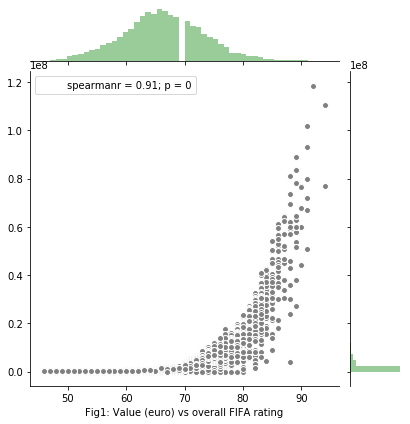

In [116]:
# Code for plot of converted value vs overall rating
from scipy import stats
correlation = fifadata['Value_converted'].corr(fifadata.Overall
                                                , method = 'spearman')
#fig, ax = sns.jointplot(fifadata.Overall, fifadata.Value_converted)
g = sns.JointGrid(x="Overall", y="Value_converted", data=fifadata)
g = g.plot_joint(plt.scatter, color=".5", edgecolor="white")
g = g.plot_marginals(sns.distplot, kde=False, color="g")
g = g.annotate(stats.spearmanr)
g = g.set_axis_labels('Fig1: Value (euro) vs overall FIFA rating')
#g.set_title('Value (euro) vs overall FIFA rating')

How are FIFA ratings calculated:
- 300 human editors watch real matches and try and quantify ratings
- ratings are artifically adjusted to meet real world performance (despite low attributes) and are adjusted upwards
- teams / leagues affect how the player is rated

https://www.vg247.com/2016/09/27/how-ea-calculates-fifa-17-player-ratings/

http://www.espn.com.au/football/blog/espn-fc-united/68/post/2959703/fifa-17-player-ratings-system-blends-advanced-stats-and-subjective-scouting

# Breakdown of Overall Rating by position
To understand the rating system lets have a look at the rating by position. Please note that we're removing the 0 Euro players and players without positions.

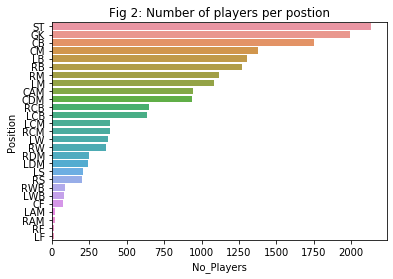

In [117]:
# Code to generate position counts
fifadata_cleaned = fifadata[fifadata.Position.notna() & fifadata.Value_converted > 0] 
positiondf = fifadata_cleaned.Position.value_counts().rename_axis('Position').reset_index(name='No_Players')
g =sns.barplot( positiondf.No_Players ,positiondf.Position)
g =g.set_title('Fig 2: Number of players per postion')

These positions can be broken down by higher level groupings of positions on the pitch and some may be interchangable. 

In [118]:
# Group positions by position on pitch
position = list(positiondf.Position)
pitch_position = ['Forward','Goal'
                  ,'Defense','Mid','Defense'
                  ,'Defense','Wing','Wing','Mid','Mid','Defense'
                  ,'Defense','Mid','Mid','Wing','Wing','Mid','Mid'
                  ,'Forward','Forward','Defense','Defense','Forward'
                  ,'Mid','Mid','Wing','Wing']
positiondict = dict(zip(position ,pitch_position))

fifadata_cleaned['Pitch_Position']= fifadata_cleaned.Position.apply(lambda x: positiondict[x])

C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Fig 3: Pitch postion vs value (euro) ')

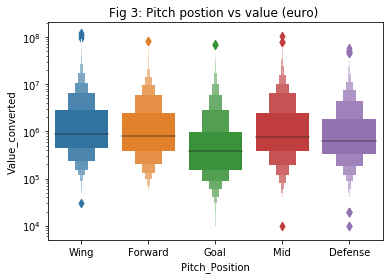

In [119]:
# Code to generate position vs value plots
f, ax = plt.subplots()
ax.set_yscale("log")

sns.boxenplot('Pitch_Position' 
              ,'Value_converted'
              ,   data = fifadata_cleaned)
ax.set_title('Fig 3: Pitch postion vs value (euro) ')

Text(0.5, 1.0, 'Fig 4: Pitch postion for Goal and Wing vs value (euro) ')

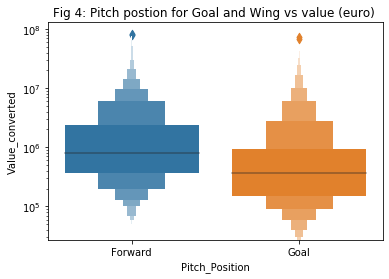

In [120]:
# Code to generate position vs value plots for Wing and Goal


f, ax = plt.subplots()
ax.set_yscale("log")
sns.boxenplot("Pitch_Position"
              , "Value_converted"
              , data =fifadata_cleaned[fifadata_cleaned.Pitch_Position.isin(['Forward','Goal'])])
ax.set_title('Fig 4: Pitch postion for Goal and Wing vs value (euro) ')
#ax.annotate(t_test_msg,xy=(2, 1))


In [121]:
# RUN a t test
from scipy.stats import ttest_ind, ttest_ind_from_stats
fwdvalue = fifadata_cleaned[fifadata_cleaned.Pitch_Position == 'Forward']['Value_converted']
goalvalue = fifadata_cleaned[fifadata_cleaned.Pitch_Position == 'Goal']['Value_converted']

t, p = ttest_ind(fwdvalue, goalvalue, equal_var=False)
t_test_msg = "ttest_ind: t = "+str(t) +" p = " + str(p)
# p value is < alpha therefore we reject the null hyp


C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Fig 5: Pitch postion vs rating to cost ratio ')

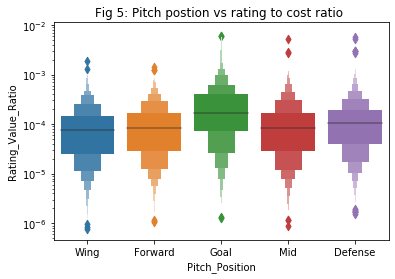

In [123]:
# Rating ratio by positions
fifadata_cleaned ['Rating_Value_Ratio'] = fifadata_cleaned.Overall/fifadata_cleaned.Value_converted

f, ax = plt.subplots()
ax.set_yscale("log")
sns.boxenplot("Pitch_Position"
              , "Rating_Value_Ratio"
              , data =fifadata_cleaned)
ax.set_title('Fig 5: Pitch postion vs rating to cost ratio ')


From Figures 3-5 we should treat model the different positions differently in order to maximize value (measured by the rating to cost ratio)

In order to establish a baseline the provided FIFA data was combined with Soccer ranking data from [fivethirtyeight](https://projects.fivethirtyeight.com/global-club-soccer-rankings/)

Seen below are the top 20 clubs and their respective mean overall ratings

In [172]:
# get club ranking table
fifaclub_overall = fifadata_cleaned.groupby('Club') \
.agg({'Overall': ['mean'] 
      , 'International Reputation':['mean']
       , 'Value_converted':['sum']
     }) \
.reset_index()

fifaclub_overall.columns = [' '.join(col) for col in fifaclub_overall.columns]
spi_ranking = pd.read_csv('data/spi_global_rankings.csv')




def sanitize_club_name(clubnames):
    """
    Sanitizes the club names to improve match rates by lowering case and removing white spaces
    Args:
        clubnames( pd.Series): A pandas series consisting of the club names
    Returns:
        clubnames (pd.Series): the sanitized list
    """
    clubnames = clubnames.lower()
    clubnames = clubnames.rstrip()
    clubnames = clubnames.lstrip()
    clubnames = clubnames.replace('fc','')
    clubnames = clubnames.replace('salonika','')
    clubnames = clubnames.replace('münchen','munich')
    return(clubnames)

spi_ranking.name = spi_ranking.name.apply(sanitize_club_name)
fifaclub_overall['Club '] =fifaclub_overall['Club '].apply(sanitize_club_name)





# ranked_clubs = pd.merge(spi_ranking
#          , fifaclub_overall
#          , left_on = 'name'
#          , right_on = 'Club '
#          , how = 'left'
#      )

from fuzzymatcher import link_table
import fuzzymatcher

ranked_clubs = fuzzymatcher.fuzzy_left_join(spi_ranking
         , fifaclub_overall
         , left_on = 'name'
         , right_on = 'Club ')

ranked_clubs = ranked_clubs.dropna()


# ranked_clubs.columns

ranked_clubs.columns = ['best_match_score', '__id_left', '__id_right', 'rank', 'prev_rank',
       'name', 'league', 'off', 'def', 'spi', 'Club', 'Overall_rating_mean',
       'International_Reputation_mean', 'Player_value_sum' ]


ranked_clubs[['name','Overall_rating_mean',
              'Player_value_sum','spi','rank']] \
.head(20)

,name,Overall_rating_mean,Player_value_sum,spi,rank
0,manchester city,84.142857,767400000.0,94.39,1
1,bayern munich,83.950000,673800000.0,93.50,2
2,liverpool,81.521739,570000000.0,92.98,3
3,barcelona,84.476190,830000000.0,91.74,4
4,paris saint-germain,82.571429,613300000.0,85.66,5
5,chelsea,81.666667,596000000.0,85.06,6
6,real madrid,84.545455,856500000.0,84.54,7
7,atletico madrid,83.450000,636500000.0,84.19,8
9,olympiacos,76.222222,74900000.0,83.35,9
10,ajax,78.928571,215200000.0,82.85,10


Below are the top Overall ranked players for each position

In [125]:
# top players by position
fifadata_cleaned \
.groupby('Pitch_Position') \
.apply(lambda x: x.sort_values(["Overall"] , ascending=False)) \
.reset_index(drop=True) \
.groupby('Pitch_Position').head(1) \
[['Name', 'Overall','Club','Nationality', 'Pitch_Position','Composure']]

,Name,Overall,Club,Nationality,Pitch_Position,Composure
0,Sergio Ramos,91,Real Madrid,Spain,Defense,82.0
5775,Cristiano Ronaldo,94,Juventus,Portugal,Forward,95.0
8386,De Gea,91,Manchester United,Spain,Goal,68.0
10375,K. De Bruyne,91,Manchester City,Belgium,Mid,88.0
14937,L. Messi,94,FC Barcelona,Argentina,Wing,96.0


# Niave Model 

Configurations of soccer teams can depend on many factors including favored attack/defense, team loyalty and leagues. 

For the rest of this analysis the top rated players will be selected. This dataset will be used to select **which players are good deals for their given position**. Put another way this analysis is to select the players with the best ROI.

## Assumptions:
- Fifa overall ranking will be the determining factor for deciding on a player
- Specific position considerations will be ignored
- Teams/leagues will be ignored
- Player Values ar the best way or predicting the auction value

## Process
For each pitch position
- Down select data (Ranking > 75  & by pitch position)
- Fit an XGboost model to the scaled ratio of rating to value
- Use the important variables to fit a kmeans for clusterin
- Use the clustering to find the most value for money players ,sorting the top 15 remaining percent and ordering by cost ratio


In [126]:
# Down selecting  and creating scaled ratio
original = fifadata_cleaned 
fifadata_cleaned = fifadata_cleaned[fifadata_cleaned.Overall >= 75 ]
fifadata_cleaned['ratingratio'] = fifadata_cleaned['Overall']/fifadata_cleaned.Value_converted


from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x = fifadata_cleaned[['ratingratio']].values
scaled_ratio = min_max_scaler.fit_transform(x)
fifadata_cleaned['scaled_rating_ratio'] = scaled_ratio
f, ax = plt.subplots()
sns.distplot(scaled_ratio)
ax.set_title('Fig 6: Scaled rating to cost ratio ')

C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [182]:
# utility functions for training
import xgboost as xgb

player_features = ['Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes',
                   'Age', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type'
                  ]
# Preferred Foot, Work Rate, Body Type

def model_rating(df, pitchposition ,player_features, trainon = 'scaled_rating_ratio'):
    '''
    Trains a model to pickup what features make a good player for a given pitch postion
    Args:
        df (pd.DataFrame): Pandas dataframe containing all the user data
        pitchpos (string): The pitch position to train the model on
        player_features (list of strings): the list to of features to train the model on
        trainon (string): the feature to model
    Returns:
        Trained Xgb model
    '''
    print('training for', trainon)
    param = {'max_depth': 2
             , 'eta': 1
             , 'silent': 1
           }
    param['nthread'] = 4
    param['eval_metric'] = 'rmse'
    df = df[df.Pitch_Position ==pitchposition ]
    Xdata = df[player_features]
    Xdata = pd.get_dummies(Xdata)
    ydata = df[trainon]
    dtrain = xgb.DMatrix(Xdata, label=ydata)
    num_round = 100
    bst = xgb.train(param, dtrain, num_round)
    xgb.plot_importance(bst)
    return(bst)

    
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def find_clusters(df, pitchposition , important_variables):
    '''
    Args:
        df (pd.DataFrame): Pandas dataframe containing all the user data
        pitchpos (string): The pitch position to train the model on
        important_variables (list of strings): list of important variables determined by 
        examining output of model_rating
    Returns:
        Scree plot for number of clusters
    '''
    df = df[df.Pitch_Position ==pitchposition ]
    df = pd.get_dummies(df)
    kmeansdata = df[important_variables]
    Sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(kmeansdata)
        Sum_of_squared_distances.append(km.inertia_)
    fig, axs = plt.subplots(ncols=1, nrows=1)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Fig 7: Elbow Method For Optimal k')
    plt.show()
      

from sklearn.decomposition import PCA
import numpy as np

def plot_cluster(df, pitchposition , important_variables, k_clusters):
    '''
    Args:
        df (pd.DataFrame): Pandas dataframe containing all the user data
        pitchpos (string): The pitch position to train the model on
        important_variables (list of strings): list of important variables determined by 
        examining output of model_rating 
        nclusters (int) : the number of clusters determined for plotting the pitch position
    Returns:
        dataframe of player clusters along with diagnostic plots
    '''
    df = df[df.Pitch_Position ==pitchposition ]
    

    playerid = df['ID']
    playername = df.Name
    Overall = df['Overall']
    Value_converted = df.Value_converted
    Cost = df.Value_converted.apply(np.log)
    #Score the dataset
    df = pd.get_dummies(df)
    kmeansdata = df[important_variables]
    km = KMeans(k_clusters)
    km = km.fit(kmeansdata)
    pred_classes = km.predict(kmeansdata)
    
    
    pca = PCA(n_components=2)
    plotdata = pca.fit_transform(kmeansdata)
    x  = [pc[0] for pc in plotdata ]
    y  = [pc[1] for pc in plotdata ]
    
    fig, axs = plt.subplots(ncols=1, nrows=3)
    
    sns.scatterplot(x,y,hue=pred_classes,  ax=axs[0])
    
    sns.boxplot(pred_classes, Overall, ax=axs[1])
    sns.boxplot( pred_classes, Cost,  ax=axs[2])
    

    
    player_cluster_allocations = np.array([playerid,Overall, Cost,pred_classes, Value_converted, playername])
    player_cluster_allocations =pd.DataFrame(player_cluster_allocations.T
                                            ,  columns= ['playerid','Overall', 'Cost','pred_classes','Value_converted','playername'] 
                                             , index = range(player_cluster_allocations.shape[1])
                                            )
    return(player_cluster_allocations)

## Analysis for Defense

training for scaled_rating_ratio


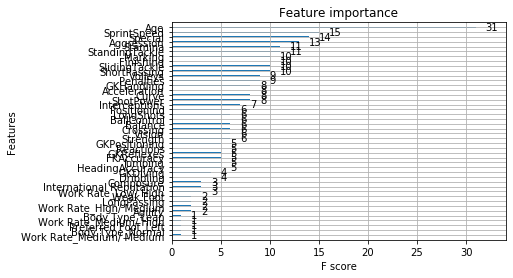

In [183]:
# What are the important variables for a given position
defmod = model_rating(fifadata_cleaned , 'Defense', player_features,'scaled_rating_ratio')
def_impvars = list(defmod.get_fscore().keys())


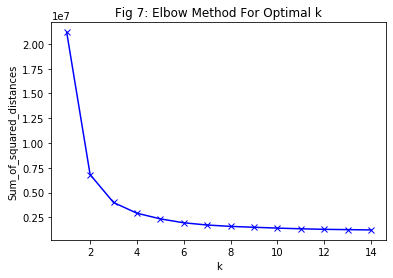

In [184]:
# cluster diagnostic plot
find_clusters(fifadata_cleaned , 'Defense', def_impvars)

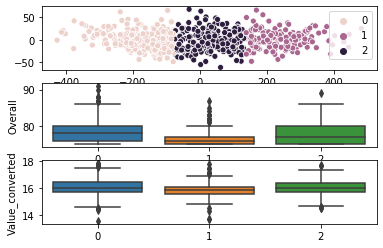

In [185]:
# Cluser diagnostic plots
clusterassignments = plot_cluster(fifadata_cleaned , 'Defense', def_impvars, 3)


C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


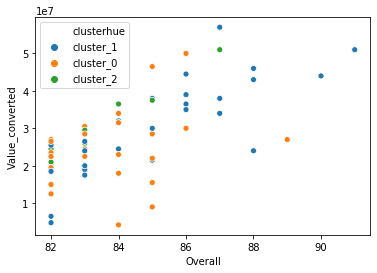

In [178]:
# Plot the top 15% range with cluster and prices
plotarea = clusterassignments [(clusterassignments['Overall'] > np.percentile(clusterassignments['Overall'] , 85)) ]
plotarea['clusterhue'] = 'cluster_'+clusterassignments.pred_classes.apply(lambda x: str(x))
sns.scatterplot('Overall', 'Value_converted' 
                , hue = 'clusterhue'
                , data =plotarea )

The table below shows the remaining top 15 percent of players ordered by their rating to cost ratio

In [186]:
# determine the best deal in every cluster
clusterassignments['ratingratio'] = clusterassignments['Overall']/clusterassignments.Value_converted

clusterassignments[clusterassignments['Overall'] > np.percentile(clusterassignments['Overall'] , 85)]. \
groupby('pred_classes') \
.apply(lambda x: x.sort_values(["ratingratio","Overall"] , ascending=False))  \
.reset_index(drop=True) \
.groupby('pred_classes').head(5)

,playerid,Overall,Cost,pred_classes,Value_converted,playername,ratingratio
0,146530,82,15.3841,0,4.8e+06,Dani Alves,1.70833e-05
1,230225,82,15.6873,0,6.5e+06,Juiano Mestres,1.26154e-05
2,171919,85,16.0127,0,9e+06,Naldo,9.44444e-06
3,185103,82,16.3412,0,1.25e+07,A. Kolarov,6.56e-06
4,179944,83,16.6777,0,1.75e+07,David Luiz,4.74286e-06
37,168530,82,16.3412,1,1.25e+07,Jardel,6.56e-06
38,179847,82,16.5236,1,1.5e+07,F. Fazio,5.46667e-06
39,190547,83,16.7599,1,1.9e+07,K. Glik,4.36842e-06
40,197655,82,16.86,1,2.1e+07,S. Coates,3.90476e-06
41,211320,82,17.0142,1,2.45e+07,D. Rugani,3.34694e-06


## Analysis for Forwards

training for scaled_rating_ratio


C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


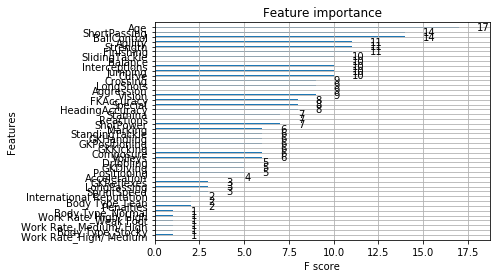

In [187]:
#What are the important variables for a given position


defmod = model_rating(fifadata_cleaned , 'Forward', player_features)
#pd.get_dummies(fifadata_cleaned)
def_impvars = list(defmod.get_fscore().keys())

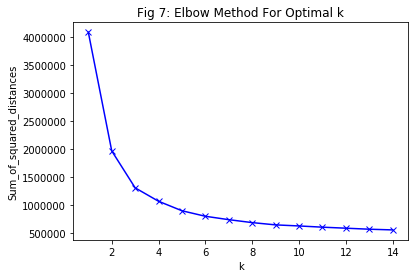

In [188]:
# cluster diagnostic plot
find_clusters(fifadata_cleaned , 'Forward', def_impvars)

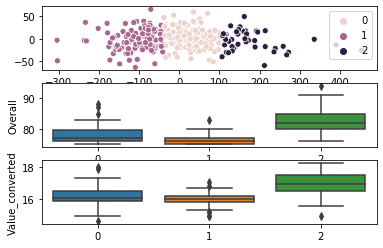

In [189]:
# Cluster assignment diagnostic
clusterassignments = plot_cluster(fifadata_cleaned , 'Forward', def_impvars,3)


C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


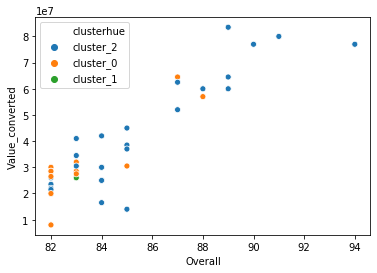

In [190]:
# Plot the Value vs rating for the remaining top 10 percent of players
plotarea = clusterassignments [(clusterassignments['Overall'] > np.percentile(clusterassignments['Overall'] ,85)) ]
plotarea['clusterhue'] = 'cluster_'+clusterassignments.pred_classes.apply(lambda x: str(x))

fig, axs = plt.subplots(ncols=1, nrows=1)

sns.scatterplot('Overall', 'Value_converted' 
                , hue = 'clusterhue'
                , data =plotarea )

In [80]:

clusterassignments['ratingratio'] = clusterassignments['Overall']/clusterassignments.Value_converted

clusterassignments[clusterassignments['Overall'] > np.percentile(clusterassignments['Overall'] , 90)]. \
groupby('pred_classes') \
.apply(lambda x: x.sort_values(["ratingratio","Overall"] , ascending=False))  \
.reset_index(drop=True) \
.groupby('pred_classes').head(5)

,playerid,Overall,Cost,pred_classes,Value_converted,playername,ratingratio
0,189068,83,17.0736,0,2.6e+07,B. Dost,3.19231e-06
1,41236,85,16.4546,1,1.4e+07,Z. Ibrahimović,6.07143e-06
2,176769,84,16.6189,1,1.65e+07,Jonas,5.09091e-06
3,181783,84,17.0344,1,2.5e+07,M. Mandžukić,3.36e-06
4,167397,84,17.0344,1,2.5e+07,Falcao,3.36e-06
5,192629,84,17.2167,1,3e+07,Iago Aspas,2.8e-06
23,186627,83,17.1297,2,2.75e+07,M. Balotelli,3.01818e-06
24,230294,83,17.1654,2,2.85e+07,Louri Beretta,2.91228e-06
25,180930,85,17.2332,2,3.05e+07,E. Džeko,2.78689e-06
26,208093,83,17.2812,2,3.2e+07,Gerard Moreno,2.59375e-06


training for Overall


C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


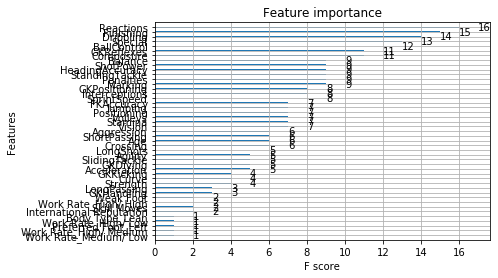

In [164]:
defmod = model_rating(fifadata_cleaned , 'Wing', player_features)
#pd.get_dummies(fifadata_cleaned)
def_impvars = list(defmod.get_fscore().keys())

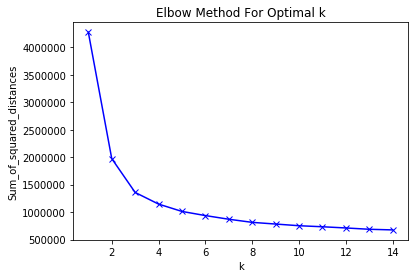

In [165]:
find_clusters(fifadata_cleaned , 'Wing', def_impvars)

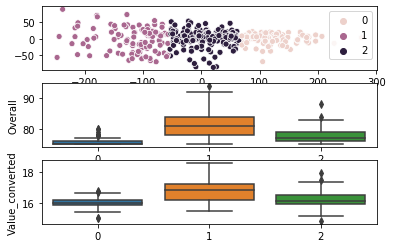

In [166]:
clusterassignments = plot_cluster(fifadata_cleaned , 'Wing', def_impvars,3)


C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<IPython.core.display.Javascript object>


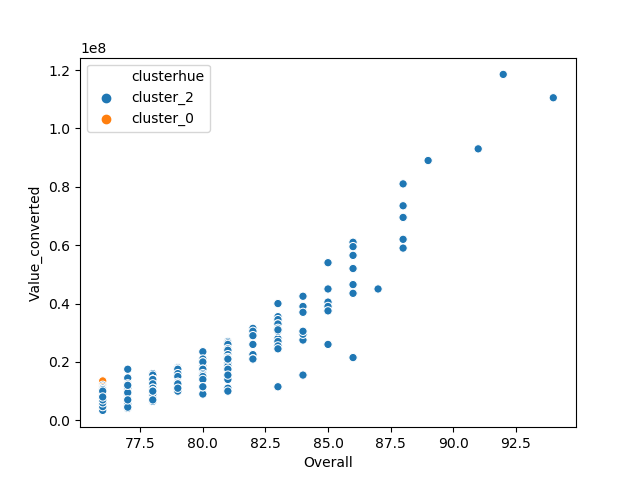

In [339]:
plotarea = clusterassignments [(clusterassignments['Overall'] > np.percentile(clusterassignments['Overall'] , 90)) ]
plotarea['clusterhue'] = 'cluster_'+clusterassignments.pred_classes.apply(lambda x: str(x))

fig, axs = plt.subplots(ncols=1, nrows=1)

sns.scatterplot('Overall', 'Value_converted' 
                , hue = 'clusterhue'
                , data =plotarea )

C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


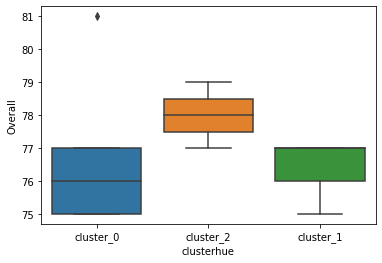

In [191]:
# determine the best deal in every cluster
clusterassignments['ratingratio'] = clusterassignments.Overall/clusterassignments.Value_converted
plotarea = clusterassignments [(clusterassignments['ratingratio'] > np.percentile(clusterassignments['ratingratio'] , 90)) ]
plotarea['clusterhue'] = 'cluster_'+clusterassignments.pred_classes.apply(lambda x: str(x))


fig, axs = plt.subplots(ncols=1, nrows=1)
sns.boxplot(plotarea.clusterhue, plotarea.Overall)

In [192]:
# determine the best deal in every cluster
clusterassignments[clusterassignments['Overall'] > np.percentile(clusterassignments['Overall'] , 85)]. \
groupby('pred_classes') \
.apply(lambda x: x.sort_values(["ratingratio","Overall"] , ascending=False))  \
.reset_index(drop=True) \
.groupby('pred_classes').head(5)

,playerid,Overall,Cost,pred_classes,Value_converted,playername,ratingratio
0,113422,82,15.895,0,8e+06,David Villa,1.025e-05
1,106231,82,15.895,0,8e+06,Aduriz,1.025e-05
2,184431,82,16.8112,0,2e+07,S. Giovinco,4.1e-06
3,178509,82,16.8112,0,2e+07,O. Giroud,4.1e-06
4,195093,82,17.0927,0,2.65e+07,Willian José,3.09434e-06
15,189068,83,17.0736,1,2.6e+07,B. Dost,3.19231e-06
16,41236,85,16.4546,2,1.4e+07,Z. Ibrahimović,6.07143e-06
17,176769,84,16.6189,2,1.65e+07,Jonas,5.09091e-06
18,208830,82,16.8112,2,2e+07,J. Vardy,4.1e-06
19,183574,82,16.8836,2,2.15e+07,M. Kruse,3.81395e-06


# APPENDIX

## Potential future work
harmonic mean of Potential and Rating
Find combinatorial possibilites

In [ ]:
sns.jointplot(fifadata.Potential, fifadata.Value_converted)